In [37]:
# sci-kit image documentation: 
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_haar_extraction_selection_classification.html
import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

# for loading and preprocessing images
import pandas as pd
from PIL import Image
import pathlib

In [2]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1], feature_type=feature_type, feature_coord=feature_coord)

In [19]:
# loading data
DATA_DIR = "facial_expressions/data"
IMAGE_DIR = "facial_expressions/images"
data = pd.read_csv(f'{DATA_DIR}/legend.csv')
data['emotion'] = data['emotion'].str.lower()
# prepping datasets
X_temp = []
# ran into too many files open error: https://stackoverflow.com/questions/29234413/too-many-open-files-error-when-opening-and-loading-images-in-pillow
# find the minimum width and height and I can resize all images to that shape
min_width = 1000
min_height = 1000
for image in data['image']:
    temp = Image.open(IMAGE_DIR + '/' + image)
    keep = temp.copy().convert('L')
    min_width = min(min_width, keep.size[0])
    min_height = min(min_height, keep.size[1])
    X_temp.append(keep)
    temp.close()
images = np.array([np.asarray(image.resize((min_width, min_height))) for image in X_temp])

In [20]:
# computing the features
feature_types = ['type-2-x', 'type-2-y','type-3-x', 'type-3-y','type-4']
# build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)

# compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_full_feature_comp = time() - t_start

# label images with emotion
Y = np.array(data['emotion'])

# spliting data in to training and validation sets
split_factor = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=split_factor, stratify=Y)

# extract all possible features
feature_coord, feature_type = haar_like_feature_coord(width=images.shape[2],height=images.shape[1],feature_type=feature_types)

In [40]:
# train a random forest classifiers with different number of estimators
n_estimators = [i for i in range(10, 101, 10)]
training_times = [0] * len(n_estimators)
accuracy_rates = [0] * len(n_estimators)
training_errors = [0] * len(n_estimators)
testing_errors = [0] * len(n_estimators)
for i, n_estimator in enumerate(n_estimators):
    clf = RandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, random_state=0, class_weight='balanced')
    t_start = time()
    clf.fit(X_train, Y_train)
    training_times[i] = time() - t_start
    accuracy_rates[i] = clf.score(X, Y)
    training_errors[i] = 1-clf.score(X_train, Y_train)
    testing_errors[i] = 1-clf.score(X_test, Y_test)

In [108]:
def plotFunction(ax, x, y, title, xlabel, ylabel):
    ax.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.grid()

In [109]:
def plotComparisons(x, training_times, accuracy_rates, training_errors, testing_errors, xlabel):
    fig, axes = plt.subplots(2, 2)
    plotFunction(axes[0][0], x, training_times, "Training Times", xlabel, "Training Time (s)")
    plotFunction(axes[0][1], x, accuracy_rates, "Accuracy Rates", xlabel, "Accuracy Rates")
    plotFunction(axes[1][0], x, training_errors, "Training Errors", xlabel, "Training_Errors")
    plotFunction(axes[1][1], x, testing_errors, "Testing Errors", xlabel, "Testing_Errors")
    fig.subplots_adjust(hspace=.5, wspace=.5)
    plt.show()

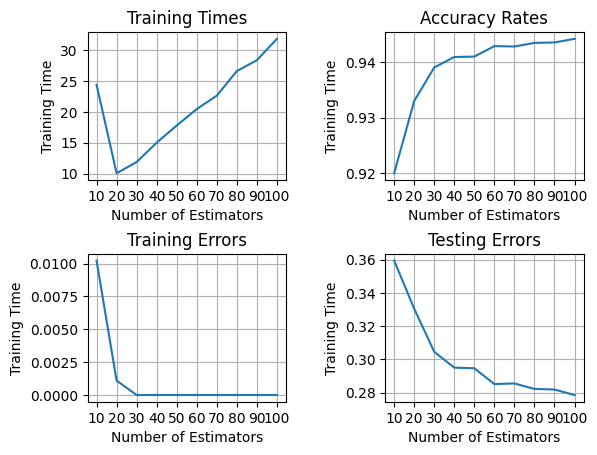

In [91]:
plotComparisons(n_estimators, training_times, accuracy_rates, training_errors, testing_errors, "Number of Estimators")

I will probably have 60 of estimators because training time is not too long and accuracy rate was hitting its plateau, training errors is 0 which indicates overfitting but I can find better max_depth, and finally testing error is also pretty low.

In [140]:
max_depths = [i for i in range(8, 16)]
training_times = [0] * len(max_depths)
accuracy_rates = [0] * len(max_depths)
training_errors = [0] * len(max_depths)
testing_errors = [0] * len(max_depths)
for i, max_depth in enumerate(max_depths):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=60, n_jobs=-1, random_state=0, class_weight='balanced')
    t_start = time()
    clf.fit(X_train, Y_train)
    training_times[i] = time() - t_start
    accuracy_rates[i] = clf.score(X, Y)
    training_errors[i] = 1-clf.score(X_train, Y_train)
    testing_errors[i] = 1-clf.score(X_test, Y_test)

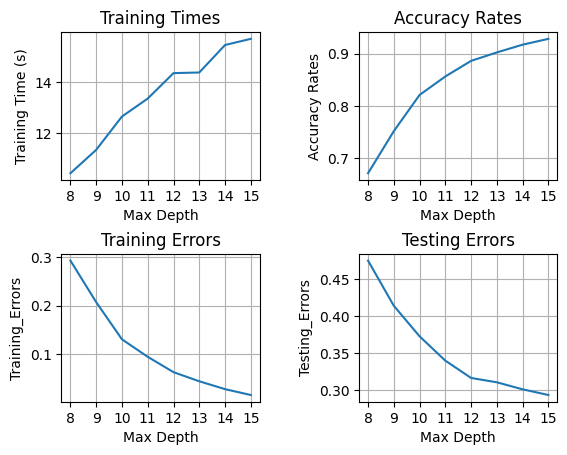

In [141]:
plotComparisons(max_depths, training_times, accuracy_rates, training_errors, testing_errors, "Max Depth")

In [142]:
print(testing_errors)

[0.4751643535427319, 0.4141709276844412, 0.372899926953981, 0.3400292184075968, 0.31665449233016796, 0.31081081081081086, 0.3013148283418554, 0.293644996347699]


From max_depth=12 onward, testing error does not vary as much so max_depth=12 is probably optimal for this dataset.

In [149]:
# set up classifier with optimal parameters
clf = RandomForestClassifier(max_depth=12, n_estimators=60, n_jobs=-1, random_state=0, class_weight='balanced')
t_start = time()
clf.fit(X_train, Y_train)
training_time = time()-t_start
accuracy_rate = clf.score(X, Y)
training_error = 1-clf.score(X_train, Y_train)
testing_error = 1-clf.score(X_test, Y_test)

In [155]:
print('Time Taken to Compute Features (s):', time_full_feature_comp)
print('Training Time (Optimized Parameters) (s):', training_time)
print('Optimized Accuracy (Optimized Parameters):', accuracy_rate)
print('Training Error (Optimized Parameters):', training_error)
print('Testing Error (Optimized Parameters):', testing_error)

Time Taken to Compute Features (s): 1074.2258758544922
Training Time (Optimized Parameters) (s): 16.12431001663208
Optimized Accuracy (Optimized Parameters): 0.8863403944485025
Training Error (Optimized Parameters): 0.06291088385682986
Testing Error (Optimized Parameters): 0.31665449233016796


In [179]:
def accuracyByEmotion(X, Y, emotion_wanted):
    X1 = np.array([X[i] for i, emotion in enumerate(Y) if emotion==emotion_wanted])
    Y1 = np.array([emotion_wanted] * len(X1))
    accuracy_rate = clf.score(X1, Y1)
    print('Accuracy Rate of', emotion, ':', accuracy_rate)

In [180]:
for emotion in np.unique(Y):
    accuracyByEmotion(X, Y, emotion)

Accuracy Rate of anger : 0.8174603174603174
Accuracy Rate of contempt : 0.7777777777777778
Accuracy Rate of disgust : 0.8557692307692307
Accuracy Rate of fear : 0.8095238095238095
Accuracy Rate of happiness : 0.9187148876404494
Accuracy Rate of neutral : 0.8724519510774607
Accuracy Rate of sadness : 0.7985074626865671
Accuracy Rate of surprise : 0.779891304347826


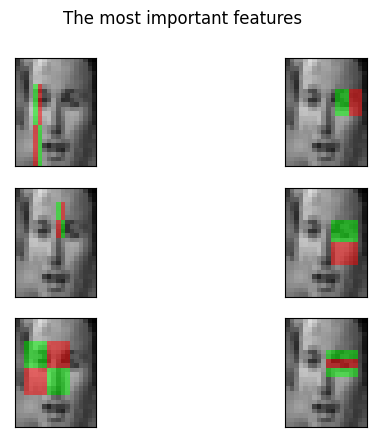

In [153]:
# sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]
fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[10]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')
plt.show()